## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import eli5
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
pd.pandas.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

In [2]:
#Helper funcs
def dropper(dflist, columnlist):
    for i in dflist:
        i.drop(columnlist, axis=1, inplace=True)

In [3]:
train = pd.read_csv("Data/Train.csv")
test = pd.read_csv("Data/Test.csv")
# test2 used for child_id column when generating predictions
test2 = pd.read_csv('Data/Test.csv')
ss = pd.read_csv('Data/SampleSubmission.csv')

In [4]:
train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_except

In [5]:
X = train.drop(['target','child_id'], axis=1)
test = test.drop(['child_id'], axis=1)
Y = train.target

In [6]:
print(X.shape, Y.shape)

(8585, 677) (8585,)


In [7]:
#Getting distributions of different variable types
numerical_vars = [col for col in X.columns if X[col].dtype != 'object']
categorical_vars = [col for col in X.columns if X[col].dtype == 'object']

In [8]:
print(len(numerical_vars), len(categorical_vars))

159 518


Breaking down the categorical variables into their unique value counts

In [9]:
categorical_unique_value_counts = []
for i in categorical_vars:
    categorical_unique_value_counts.append(len(X[i].unique()))

In [10]:
list(range(len(categorical_unique_value_counts)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

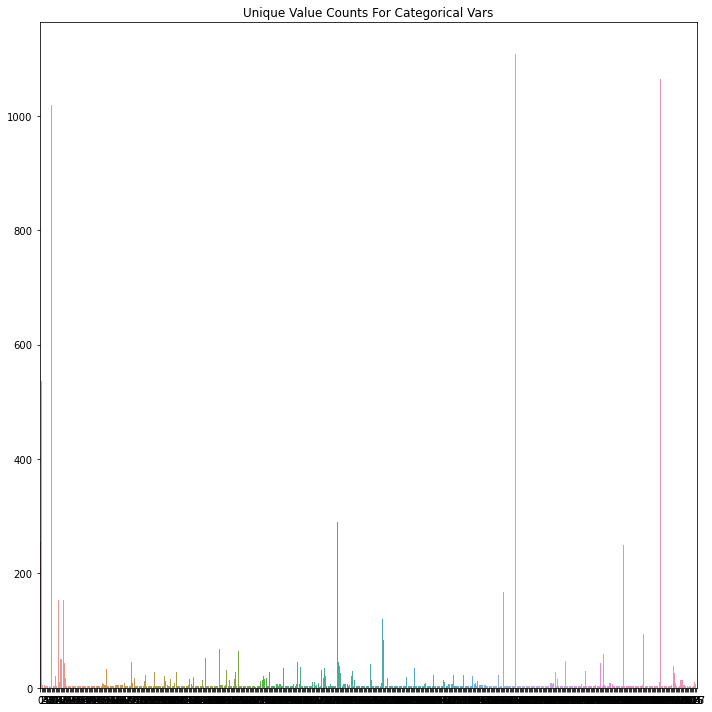

In [11]:
categorical_unique_value_counts
plt.figure(figsize=(10,10))
sns.barplot(x=list(range(len(categorical_unique_value_counts))), y = categorical_unique_value_counts)
plt.title('Unique Value Counts For Categorical Vars')
plt.tight_layout()
plt.show()


Seperating categorical values into high and low cardinal features as well as binary features

In [12]:
high_cardinal = []
low_cardinal = []
binary_cat = []
for index, i in enumerate(categorical_unique_value_counts):
    if i==3:
        binary_cat.append(categorical_vars[index])
    if i>50:
        high_cardinal.append(categorical_vars[index])
    else:
        low_cardinal.append(categorical_vars[index])
      

Plotting the distribution of types of categorical values

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Counts')

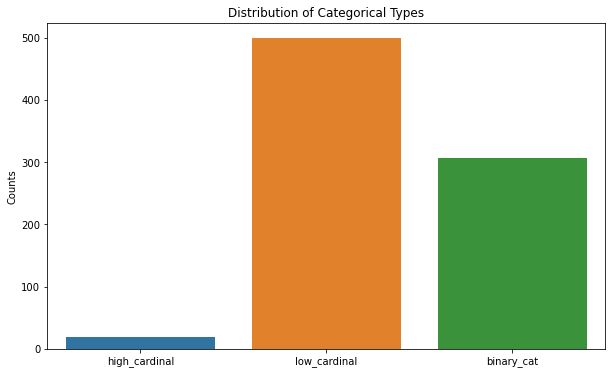

In [13]:
plt.figure(figsize=(10,6))
plt.title("Distribution of Categorical Types")
sns.barplot(x=["high_cardinal","low_cardinal", "binary_cat"], y=[len(high_cardinal), len(low_cardinal), len(binary_cat)])
plt.ylabel("Counts")

### Converting to function for future use

In [14]:
def categorical_grouper(df):
    high_cardinal = []
    low_cardinal = []
    binary_cat = []
    categorical_vars = [col for col in df.columns if df[col].dtype == 'object']
    categorical_unique_value_counts = []
    for i in categorical_vars:
        categorical_unique_value_counts.append(len(df[i].unique()))
    for index, i in enumerate(categorical_unique_value_counts):
        if i==3:
            binary_cat.append(categorical_vars[index])
        if i>50:
            high_cardinal.append(categorical_vars[index])
        else:
            low_cardinal.append(categorical_vars[index])

    plt.figure(figsize=(10,6))
    plt.title("Distribution of Categorical Types")
    sns.barplot(x=["high_cardinal","low_cardinal", "binary_cat"], y=[len(high_cardinal), len(low_cardinal), len(binary_cat)])
    plt.ylabel("Counts")
    plt.show()
    
    return list(high_cardinal), list(low_cardinal), list(binary_cat)

In [15]:
def categorical_grouper_without_plot(df):
    high_cardinal = []
    low_cardinal = []
    binary_cat = []
    categorical_vars = [col for col in df.columns if df[col].dtype == 'object']
    categorical_unique_value_counts = []
    for i in categorical_vars:
        categorical_unique_value_counts.append(len(df[i].unique()))
    for index, i in enumerate(categorical_unique_value_counts):
        if i==3:
            binary_cat.append(categorical_vars[index])
        if i>50:
            high_cardinal.append(categorical_vars[index])
        else:
            low_cardinal.append(categorical_vars[index])
    return list(high_cardinal), list(low_cardinal), list(binary_cat)

## Fixing the binary categorical values

In [16]:
yes_no_cat_vars = []
for i in binary_cat:
    if 'Yes' in X[i].unique():
        yes_no_cat_vars.append(i)

Fixing the yes and no categorical variables

In [17]:
X[yes_no_cat_vars].shape

(8585, 295)

In [18]:
for i in yes_no_cat_vars:
    X[i] = X[i].map({"No":0, "Yes":1})
    test[i] = test[i].map({"No":0, "Yes":1})

---

Remaining categorical vars

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

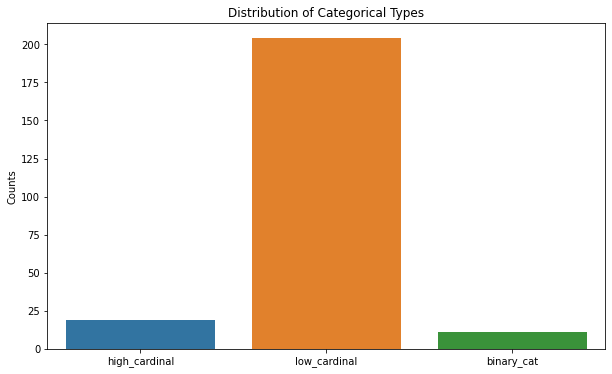

In [19]:
high_card, low_card, bin_cat = categorical_grouper(X)

Fixing the pra_gender column. Use 1 hot encoding.

In [20]:
test[bin_cat].head()

,pra_gender,pri_mobile,pri_languageother,pri_clinic_travelother,teacher_social_met,teacher_emotional_met,teacher_selfcare_met,obs_shared,urban,positionother,positionotherreason
0,NaN,Based at a specific location,NaN,NaN,Meets the standard,Meets the standard,Meets the standard,Only this ECD programme,Urban,NaN,NaN
1,NaN,Based at a specific location,NaN,NaN,Meets the standard,Meets the standard,Meets the standard,Only this ECD programme,Urban,NaN,NaN
2,NaN,Based at a specific location,NaN,NaN,Does not meet standard,Does not meet standard,NaN,Other activities as well,Rural,NaN,NaN
3,NaN,Based at a specific location,NaN,NaN,Meets the standard,Meets the standard,Meets the standard,Only this ECD programme,Urban,NaN,NaN
4,NaN,Based at a specific location,NaN,NaN,Does not meet standard,Does not meet standard,Does not meet standard,Only this ECD programme,Urban,NaN,NaN


## OneHotEncoding gender columns

In [21]:
#Looking at distribution counts of genders. Data is skewed toward female, although mean score between males and females are not
#too different
print(X["pra_gender"].value_counts())
print(train[X["pra_gender"]=="Male"].target.mean(), train[X["pra_gender"]=="Female"].target.mean())

Female    1603
Male        26
Name: pra_gender, dtype: int64
41.59653821358314 44.78500934667462


In [22]:
from sklearn.preprocessing import OneHotEncoder
def oneHotColEncoder(colnamelist, traindf, testdf):
    for i in colnamelist:
        OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(traindf[[i]]), columns=OH_encoder.get_feature_names([i]))
        OH_cols_valid = pd.DataFrame(OH_encoder.fit_transform(testdf[[i]]),columns=OH_encoder.get_feature_names([i]))
        # Remove categorical columns (will replace with one-hot encoding)
        traindf = traindf.drop(i, axis=1)
        testdf = testdf.drop(i, axis=1)
        # Add one-hot encoded columns to numerical features
        traindf = pd.concat([traindf, OH_cols_train], axis="columns")
        testdf = pd.concat([testdf, OH_cols_valid], axis="columns")
    return traindf, testdf

In [23]:
X, test = oneHotColEncoder(['pra_gender', 'child_gender'], X, test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

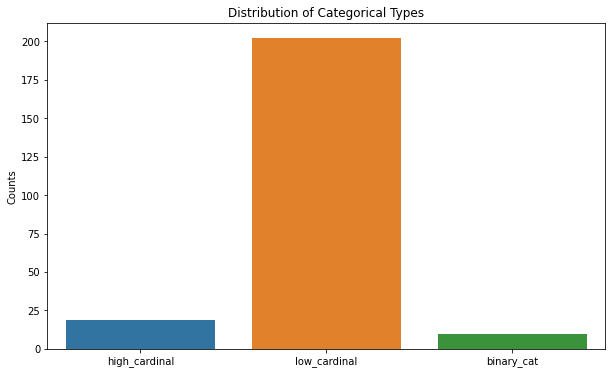

In [24]:
high_card, low_card, bin_cat = categorical_grouper(X)

In [25]:
X.head()

,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fees_paid_proportion,pri

## Ordinal encoding

Ordinal Encoding low cardinal variables with custom ordinal encoder

In [26]:
list_ordinal_reversed = ["child_stunted",'pra_engaged', "pra_agency_choice","pra_agency_explore","pra_agency_questions","pra_agency_understand", "pra_agency_play","pra_agency_learn","pra_agency_order","pra_job", "pri_bank","pri_kitchen","teacher_social_peers","teacher_social_nonaggressive","teacher_social_cooperate","teacher_social_assistance","teacher_emotional_understand","teacher_selfcare_met", "obs_shared","grade_r","certificate_registration_partial","certificate_registration_program","certificate_registration_npo","certificate_register","urban"]

In [27]:
list_ordinal_normal = ["child_grant", "pri_registered_partial", "pri_registered_programme", "pri_registered_dsd", "teacher_social_ideas", "teacher_social_initiative", "teacher_social_met","teacher_emotional_met"]

In [28]:
#Mapping all the ordinal values based on their range
unique_var_dict = {}
for i in X.columns:
    if X[i].dtype == "O":
        final_list = list(X[i].unique())
        cleanedList = [x for x in final_list if str(x) != 'nan']
        unique_var_dict.update({i:cleanedList})

In [29]:
un_list = ["child_observe_attentive", "child_observe_concentrated", "child_observe_diligent", "child_observe_interested"]
def dfMapper(column, mapping_dictionary_value):
    X[column]=X[column].map(mapping_dictionary_value)
    test[column]=test[column].map(mapping_dictionary_value)
listof_mapof_cols = [
    {'Sometimes':1, 'Often':2, 'Almost always':3, 'Almost never':-1},
    {'Sometimes':1, 'Almost never':-1, 'Often':2, 'Almost always':3},
    {'Sometimes':1, 'Almost always':3, 'Often':2, 'Almost never':-1},
    {'Sometimes':1, 'Often':2, 'Almost always':3, 'Almost never':-1}
]
for ind, i in enumerate(un_list):
    dfMapper(i, listof_mapof_cols[ind])

In [30]:
def ordinal_value_mapper(column, ls, train, test):
    mapping_dictionary_value = {k: v for v, k in enumerate(ls)}
    train[column]=train[column].map(mapping_dictionary_value)
    test[column]=test[column].map(mapping_dictionary_value)
for ele in list_ordinal_reversed:
    ordinal_value_mapper(ele,list(reversed(unique_var_dict[ele])), X, test)
for ele in list_ordinal_normal:
    ordinal_value_mapper(ele,unique_var_dict[ele], X, test)

In [31]:
high_card, low_card, bin_cat = categorical_grouper_without_plot(X)
X[low_card].head()

,child_years_in_programme,child_languages,child_age_group,prov_best,pqa_date,pqa_class_age,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_assessment_observation,pqa_assessment_systematic,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_plans,pra_date,pra_class_size_large,pra_cohort,pra_class_language,pra_plan_4yrs,pra_plan_5yrs,pra_plan_4yrsother,pra_plan_5yrsother,pra_salary,pra_education,pra_qualification,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_trainer,pra_ncf_trainerother,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_class_space_small,pra_class_space_large,pra_language,pri_mobile,pri_calc_time_open,pri_calc_time_close,pri_separate,pri_languageother,pri_toys,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_meal,pri_reason_register_year,pri_attendance,pri_fees_paid_proportion,pri_date,pri_education,pri_qualification,pri_qualificationother,pri_founder,pri_founderother,pri_same_language,pri_location,pri_locationother,pri_dsd_conditional,pri_dsd_conditional_other,pri_dsd_unregistered,pri_dsd_unregistered_other,pri_network_type,pri_email_network_forum,pri_name_network_ngo,pri_name_network_alliance,pri_name_network_other,pri_support_dsd,pri_support_dbe,pri_support_municipality,pri_support_ngo,pri_staff_employed,pri_staff_changes_reasons,pri_staff_changes_reasonsother,pri_covid_staff_salaries,pri_money,pri_moneyother,pri_funding_salary,pri_funding_salaryother,pri_clinic_travel,pri_clinic_travelother,pri_covid_awareness,pri_covid_precautions,pri_covid_awareness_other,pri_covid_precautions_other,pri_food_parents_breakfast,pri_food_parents_morning,pri_food_parents_lunch,pri_food_parents_afternoon,pri_food_type,pri_food_donor,pri_food_donorother,pri_meal_prep,pri_parents_frequency,pri_parents_contact,pri_parents_activities,pri_records,pri_support_provider,pri_support_providerother,pri_support_frequency,pri_internet_user,pri_languages,teacher_emotional_appropriate,teacher_emotional_independent,teacher_emotional_adjust,teacher_emotional_confidence,teacher_emotional_selfstarter,hle_ecd_other,hle_ind,obs_materialsother,obs_heating_census,obs_lighting_census,obs_cooking_census,obs_water,obs_waterother,obs_handwashing,obs_toilet,obs_building,obs_equipment,obs_condition_equipment,obs_date,obs_handwashingother,obs_heating,obs_lighting,obs_cooking,obs_material_display,id_prov,phase_natemis,obs_access_disability,health,healthother,other_practitioner,plan,language_child,language_assessment,facility_type,sanitation_learners,positionother,positionotherreason,sef_ind,pre_covid,language_assessment_w2,ses_cat
0,NaN,NaN,50-59 months,GAUTENG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GT,NaN,NaN,NaN,NaN,NaN,NaN,Sesotho,Sesotho,Grade R,NaN,NaN,NaN,Yes,Post COVID,NaN,NaN
1,1st year in the programme,NaN,60-69 months,KWAZULU-NATAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [32]:
X["child_years_in_programme"].unique()

array([nan, '1st year in the programme', '2nd year in programme',
       '3rd year in programme', 'Do Not Know'], dtype=object)

In [33]:
#Converting to nueric based on year stored in first index
def child_years_in_programe_categorizer(row):
    if str(row)[0] == 'n':
        return np.nan
    if str(row)[0] == 'D':
        return np.nan
    else:
        return int(str(row)[0])
X["child_years_in_programme"] = X["child_years_in_programme"].apply(child_years_in_programe_categorizer)
test["child_years_in_programme"] = test["child_years_in_programme"].apply(child_years_in_programe_categorizer)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

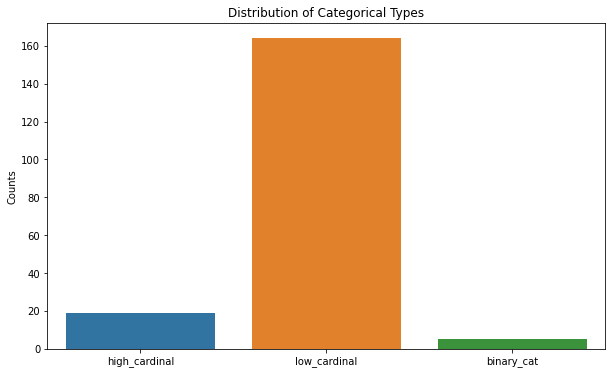

In [34]:
high_card, low_card, bin_cat = categorical_grouper(X)

In [35]:
X.head()

,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fees_paid_proportion,pri

In [36]:
high_cardinal_target_cols = ["dc_best", "mn_best", "id_mn_best", "id_dc_best","prov_best", "id_dc_best","pra_class_language","pra_education","pra_previous","pra_language","pri_facilities","pri_land","pri_education","pri_location","pri_name_network_forum", "pri_expenseother","obs_heating_census","obs_lighting_census","obs_cooking_census","obs_water","obs_building","id_prov","phase_natemis","language_child","language_assessment","facility_type","sef_ind","pre_covid"]

## Using target encoding for high cardinality features

In [37]:
def MyEstimateEncoder(column_name, X, Y, test):
    X_encode = X.sample(frac=0.25)
    y_encode = Y[X_encode.index]
    X_pretrain = X.drop(X_encode.index)
    y_train = Y[X_pretrain.index]
    from category_encoders import MEstimateEncoder

    encoder = MEstimateEncoder(cols=column_name, m=5.0)
    encoder.fit(X_encode, y_encode)

    X = encoder.transform(X)
    test = encoder.transform(test)
    return X, test

In [38]:
for i in high_cardinal_target_cols:
    X, test = MyEstimateEncoder(i, X, Y, test)

In [39]:
X[high_cardinal_target_cols]

,dc_best,mn_best,id_mn_best,id_dc_best,prov_best,id_dc_best,pra_class_language,pra_education,pra_previous,pra_language,pri_facilities,pri_land,pri_education,pri_location,pri_name_network_forum,pri_expenseother,obs_heating_census,obs_lighting_census,obs_cooking_census,obs_water,obs_building,id_prov,phase_natemis,language_child,language_assessment,facility_type,sef_ind,pre_covid
0,52.801480,52.011547,52.360076,51.227569,48.484234,51.227569,49.680358,50.239067,49.628810,49.834577,53.506849,53.924425,49.176627,49.479032,49.232534,48.964230,49.842156,49.745867,49.992522,52.954330,53.248470,47.848093,52.713946,43.950348,43.981752,54.840968,48.376283,47.659591
1,50.577139,52.145300,52.441263,53.075328,47.861500,53.075328,49.680358,50.239067,49.628810,49.834577,53.506849,53.924425,49.176627,49.479032,49.232534,48.964230,49.842156,49.745867,49.992522,52.954330,53.248470,47.965521,52.713946,48.147785,48.941969,47.704910,48.376283,56.502074
2,54.946359,54.719863,55.281537,56.225430,53.652798,56.225430,49.680358,50.239067,49.628810,49.834577,53.506849,53.924425,49.176627,49.479032,49.232534,48.964230,49.842156,49.745867,49.992522,47.823005,53.248470,53.266793,52.713946,51.339376,50.612769,54.840968,50.679122,47.659591
3,57.860138,53.159412,55.988603,56.224201,53.652798,56.224201,49.680358,50.239067,49.628810,49.834577,47.704520,41.703825,49.176627,49.479032,49.232534,48.964230,46.544789,46.562910,46.462479,44.670383,47.962077,53.266793,45.738058,51.353151,49.616263,47.704910,48.376283,47.659591
4,51.581117,42.890522,44.776003,51.482861,47.861500,51.482861,46.313087,43.206867,45.321854,44.516208,48.549569,46.773341,42.837786,45.702897,48.644650,48.706868,49.842156,49.745867,49.992522,42.247738,45.867965,47.965521,45.812968,48.147785,48.941969,47.704910,48.376283,47.659591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8580,42.675475,47.137024,43.425206,44.354236,42.456807,44.354236,38.416346,43.206867,45.114698,41.529401,42.301717,46.982592,45.469911,45.702897,38.433604,48.964230,49.842156,49.745867,49.992522,47.823005,45.867965,39.073011,45.812968,43.950348,43.981752,47.704910,48.376283,47.659591
8581,52.276636,51.707189,52.126781,51.368081,50.444362,51.368081,46.974759,43.206867,46.780841,44.795033,42.301717,44.123020,45.469911,45.597222,49.232534,47.038379,49.842156,49.745867,49.992522,47.823005,45.867965,48.690144,45.812968,45.435873,45.769317,47.704910,48.376283,47.659591
8582,40.377234,50.767815,52.598944,43.533274,42.814451,43.533274,50.481601,46.410294,46.780841,51.150149,44.397595,41.703825,46.487673,46.340423,49.232534,48.964230,49.842156,49.745867,49.992522,47.823005,45.867965,39.394064,45.812968,55.152761,54.325119,47.704910,48.376283,47.659591
8583,49.586926,46.310432,47.833676,50.009403,48.484234,50.009403,49.680358,50.239067,49.628810,49.834577,48.549569,47.759545,49.176627,49.479032,49.232534,48.964230,49.842156,49.745867,49.992522,52.954330,53.248470,47.848093,45.812968,51.353151,49.616263,47.704910,48.376283,47.659591


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

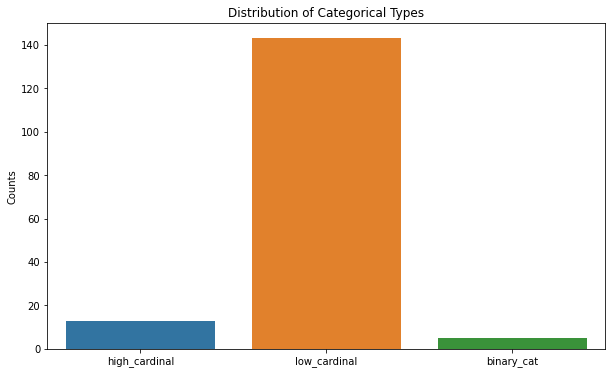

In [40]:
high_card, low_card, bin_cat = categorical_grouper(X)

## Feature Engineering

In [41]:
X.head()

,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fees_paid_proportion,pri

### Date Features

In [42]:
#Getting all the date features in the dataframe
date_feats = []
for i in list(X.columns):
    if "date" in i:
        date_feats.append(i)

In [43]:
X[date_feats]

,child_date,child_enrolment_date,pqa_date,pra_date,pri_date,obs_date
0,2022-02-03,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-03-11,NaN,NaN,NaN,NaN,NaN
3,2021-10-13,2020-01-15,NaN,NaN,NaN,NaN
4,2021-10-13,2021-10-13,2021-10-29,2021-10-29,2021-10-29,2021-10-29
...,...,...,...,...,...,...
8580,2021-11-10,2021-01-12,2021-10-19,2021-10-19,2021-11-10,2021-10-19
8581,2021-10-12,2019-01-15,2021-10-12,2021-10-12,2021-10-12,2021-10-12
8582,2021-11-02,2018-01-07,2021-10-06,2021-10-06,2021-10-06,2021-10-06
8583,2021-11-05,2021-01-15,NaN,NaN,NaN,NaN


In [44]:
#pqa_date,pra_date,pri_date,obs_date all contain the same value removing duplicates
dropper([X, test], ["pqa_date","pra_date","pri_date"])

In [45]:
date_feats = []
for i in list(X.columns):
    if "date" in i:
        date_feats.append(i)

In [46]:
date_feats.append("child_dob")

In [47]:
date_feats

['child_date', 'child_enrolment_date', 'obs_date', 'child_dob']

In [48]:
X[date_feats]

,child_date,child_enrolment_date,obs_date,child_dob
0,2022-02-03,NaN,NaN,2017-02-06
1,NaN,NaN,NaN,NaN
2,2022-03-11,NaN,NaN,2016-05-24
3,2021-10-13,2020-01-15,NaN,2017-05-08
4,2021-10-13,2021-10-13,2021-10-29,2016-12-19
...,...,...,...,...
8580,2021-11-10,2021-01-12,2021-10-19,2017-04-01
8581,2021-10-12,2019-01-15,2021-10-12,2017-02-27
8582,2021-11-02,2018-01-07,2021-10-06,2017-02-03
8583,2021-11-05,2021-01-15,NaN,2017-01-28


In [49]:
for i in date_feats:
    print(date_feats.index(i))
    try:
        print(i, date_feats[date_feats.index(i)+1])
    except:
        print("err")

0
child_date child_enrolment_date
1
child_enrolment_date obs_date
2
obs_date child_dob
3
err


In [50]:
#Generating time features
for df in [X, test]:
    for i in date_feats:
        date = pd.to_datetime(df[i],format='%Y-%m-%d')
        df[i + "year"] = date.dt.year
        df[i + "month"] = date.dt.month
        df[i + "week"] = date.dt.week
        df[i + "day"] = date.dt.day
        df[i + "dayofweek"] = date.dt.dayofweek
        #df.drop(i, axis=1, inplace=True)
    for i in date_feats:
        try:
            # deltas between
            df["delta_years" + i + date_feats[date_feats.index(i)+1]] = abs(df[i + "year"] - df[date_feats[date_feats.index(i)+1] + "year"])
            df["delta_month" + i + date_feats[date_feats.index(i)+1]] = abs(df[i + "month"] - df[date_feats[date_feats.index(i)+1] + "month"])
            df["delta_days" + i + date_feats[date_feats.index(i)+1]] = abs(df[i + "month"] - df[date_feats[date_feats.index(i)+1] + "month"])*30
        except:
            print("err")

err
err


In [51]:
#dropping the date features
for df in [X, test]:
    df.drop(date_feats, axis=1, inplace=True)

In [52]:
print(X.shape, test.shape)

(8585, 702) (3680, 702)


In [53]:
X.head()

,data_year,child_age,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_experience,pra_class_present,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fees_paid_proportion,pri_amount_funding_dsd,pri_amount_funding_fees,pri_education,pr

## Fixing the child_observe_total column

In [54]:
for df in [X, test]:
    df["child_observe_total"] = (df["child_observe_attentive"]+df["child_observe_concentrated"]+df["child_observe_diligent"]+df["child_observe_interested"])
    

In [55]:
X.head()

,data_year,child_age,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_experience,pra_class_present,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fees_paid_proportion,pri_amount_funding_dsd,pri_amount_funding_fees,pri_education,pr

In [56]:
print(X.shape, test.shape)

(8585, 702) (3680, 702)


In [57]:
def dfMapper_df(df, column, mapping_dictionary_value):
    df[column]=df[column].map(mapping_dictionary_value)
target_feats_engin = ["latitude", "child_age_group", "child_observe_total", "child_years_in_programme","dc_best"]
for i in target_feats_engin:
    X[i+"_target_mean"] = train[i]
    grouped_by_key1 = train["target"].groupby(train[i])
    dfMapper_df(X, i+"_target_mean",grouped_by_key1.mean().to_dict())
for i in target_feats_engin:
    test[i+"_target_mean"] = test[i]
    grouped_by_key1 = train["target"].groupby(test[i])
    dfMapper_df(test, i+"_target_mean",grouped_by_key1.mean().to_dict())

In [59]:
test.head()

,data_year,child_age,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_experience,pra_class_present,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fees_paid_proportion,pri_amount_funding_dsd,pri_amount_funding_fees,pri_education,pr

In [58]:
assert break

SyntaxError: invalid syntax (788468970.py, line 1)

## Mutual Information for Feature Selection

In [ ]:
X_mi = X.copy()
X_mi = X_mi.fillna(0)
y_mi = Y

# Label encoding for categoricals
for colname in X_mi.select_dtypes("object"):
    X_mi[colname], _ = X_mi[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X_mi.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_mi, y_mi, discrete_features)
mi_scores[:2] 

In [ ]:
feature_list_mi = pd.DataFrame(mi_scores[:250]).index.values.tolist()

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
X.head()

In [ ]:
#With mi
num_cols = list(set(X[feature_list_mi].select_dtypes('number')))
len(num_cols)

In [60]:
#Without mi
num_cols = list(set(X.select_dtypes('number')))
len(num_cols)

558

In [61]:
X = X[num_cols]
X = X.fillna(0)

In [62]:
X.head()

,count_staff_salary_unpaid,obs_materials_10,count_staff_all,obs_safety_2,pri_qualification_2,obs_safety_1,count_staff_paid,pri_dsd_year,count_register_year_2016,obs_safety_0,pri_records_1,obs_area_4,count_staff_paid_assistants,pri_clinic_travel_5,sef_ind,child_dateday,pri_covid_awareness_97,obs_heating_4,pri_fees,obs_area_0,obs_handwashing_2,pri_land,pra_measure_rectangle_length,pqa_class_age_5,pri_qualification_5,count_staff_qual_nqf6_9,dc_best_target_mean,pri_funding_none,pra_education,pri_registered_programme,pri_fees_amount_pv,pra_experience,pra_agency_order,pri_firstaid,child_years_in_programme_target_mean,obs_books_age,pra_cohort_0,child_observe_concentrated,count_staff_gender,pri_expenseother,pri_registered_dsd,obs_safety_5,pri_clinic_travel_1,pri_health_2,obs_materials_16,obs_hazard_7,count_staff_contract_substitute,count_staff_time_part,child_attends,latitude_target_mean,obs_access_disability_4,count_register_year_school,pri_network,obs_materials_11,obs_cooking_3,pra_training_6,dc_best,count_staff_gender_other,pri_covid_awareness_2,pra_ncf_training,obs_safety_6,pri_language_10,delta_monthchild_enrolment_dateobs_date,pra_qualification_4,pri_language_11,pri_funding_6,pra_plan_5yrs_5,pra_training_1,pri_food_type_5,pri_food_type_2,pra_agency_learn,obs_lighting_4,pra_plan_5yrs_3,pra_measure_rectangle_width,pri_expense_admin,pri_network_type_1,pri_health_4,obs_toilet_paper,pri_health_0,obs_cooking_4,pri_food_donation,pri_covid_precautions_4,obs_books,obs_equipment_2,pri_transport,pra_ind,professionals_practitioners,pri_language_4,obs_equipment_3,pri_language_3,pri_funding_4,pri_covid_awareness_4,teacher_emotional_understand,pri_qualification_97,pri_money_2,count_staff_paid_managers,count_staff_contract,pri_holidays,pra_cohort_3,child_dateweek,pra_training_4,count_register_year_2021,child_datemonth,pri_records_3,obs_classrooms,pri_covid_precautions_6,phase_natemis,obs_cooking_census,id_prov,pri_health_3,teacher_social_peers,count_register_year_2015,pre_covid,pri_qualification_1,child_dobweek,pra_plan_4yrs_4,count_staff_paid_cooks,pra_plan_5yrs_2,obs_toilets_gender,count_toilets_adults,pqa_score_relationships,obs_materials_5,pri_covid_precautions_2,grade_r,obs_fence,pra_special_referrals,pra_agency_explore,pri_funding_2,count_register_gender_male,pri_records_2,pri_meal_2,count_toilets_children,child_gender_Female,id_dc_n,teacher_selfcare_met,pri_expense_food,pri_time_close_hours,count_practitioners_age_0,count_register_year_2017,pri_fees_exceptions,obs_cooking_6,pra_qualification_6,child_dobdayofweek,delta_yearsobs_datechild_dob,pri_records_4,quintile_used,id_enumerator,pri_clinic_travel_2,count_staff_qual_nqf4_5,pra_special_training,pri_fees_amount_4_6,obs_materials_14,obs_materials_15,opening_hours,obs_hazard_8,pri_language_1,child_dobyear,pri_money__1,obs_water,pra_plans_3,count_register_year_2020,sanitation_educators,pri_qualification_0,id_prov_n,pri_language_5,obs_lighting_2,obs_equipment__1,pra_class_language,pra_gender_Male,pra_ncf_trainer_4,count_children_attendance,pri_network_type_2,pri_expense_rent,count_register_race,obs_heating_6,obs_safety_4,pri_funding_salary_4,mn_best,ward_best,pri_difficult_hear,delta_dayschild_enrolment_dateobs_date,pri_registered_npo,pri_registered_cipc,count_children_present,count_staff_time_full,pri_funding_salary_1,pri_covid_staff_retrench,pri_expense_maintenance,obs_hazard_2,pri_fees_amount,obs_materials_12,obs_hazard_97,pri_time_open_minutes,pri_health_1,obs_cooking_5,child_months_enrolment,count_staff_qual_skills,obs_toilet_3,pri_subsidy,pri_money_97,count_staff_gender_female,pra_hhsize,child_attendance,pri_funding_5,obs_materials_13,obs_toilet_clean,certificate_registration_partial,pri_covid_awareness_3,obs_safety_7,pri_qualification_7,obs_heating_7,pra_qualification_97,pri_support_provider_1,obs_materials_3,pra_engaged,pri_location,teacher_emotional_met,pri_covid_precautions_97,pri_support_provider_3,obs_heating_2,pri_bank,pri_aftercare,delta_yearschild_datechild_enrolment_date,pri_

In [63]:
print(X.shape, Y.shape)

(8585, 558) (8585,)


In [64]:
# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 333)

## Try Bayesian Optimization with LightGBM

In [65]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'rmse',
         'learning_rate': 0.05, 
         'num_iterations': 7500,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction': 0.8,
         'bagging_freq': 1,
         'feature_fraction': 0.8
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=100,
                verbose_eval=500,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_test) 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9553
[LightGBM] [Info] Number of data points in the train set: 6868, number of used features: 531
[LightGBM] [Info] Start training from score 48.703887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[376]	valid_0's rmse: 9.3751


In [66]:
Xtest  = test[num_cols]

In [67]:
%%time
errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=500,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test) 

    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
    errlgb.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    p = clf.predict(Xtest)
    
    y_pred_totlgb.append(p)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9704
[LightGBM] [Info] Number of data points in the train set: 7726, number of used features: 532
[LightGBM] [Info] Start training from score 48.757313
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 8.99728
Early stopping, best iteration is:
[409]	valid_0's rmse: 8.97335
RMSE:  8.973350578229608
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9701
[LightGBM] [Info] Number of data points in the train set: 7726, number of used features: 532
[LightGBM] [Info] Start training from score 48.608999
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 9.27651
Early stopping, best iteration is:

In [68]:
np.mean(errlgb, 0)

9.269124036921317

In [69]:
ypredlgbm = np.mean(y_pred_totlgb,0)

In [70]:
import catboost as catt
cb_model = catt.CatBoostRegressor(iterations=5000,
                             learning_rate=0.045,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                            bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=300)
cb_model.fit(X, Y,
             use_best_model=True,
             verbose=2000)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 14.8971767	total: 189ms	remaining: 15m 44s
2000:	learn: 3.9743046	total: 2m 17s	remaining: 3m 25s
4000:	learn: 2.0328789	total: 4m 28s	remaining: 1m 6s
4999:	learn: 1.5492640	total: 5m 35s	remaining: 0us


In [71]:
predscatboost = (cb_model.predict(Xtest))

In [72]:
ypredlgbm

array([55.49851645, 50.13196101, 45.25763997, ..., 49.49076133,
       33.55593279, 54.50668965])

In [73]:
predscatboost

array([55.21171337, 50.91437868, 49.07526086, ..., 48.05461265,
       29.11360736, 47.85819825])

In [74]:
ens_preds = (ypredlgbm+predscatboost)/2

In [75]:
ens_preds

array([55.35511491, 50.52316985, 47.16645042, ..., 48.77268699,
       31.33477008, 51.18244395])

In [76]:
X.shape

(8585, 558)

In [ ]:
assert break

In [ ]:
%%time
# Get the top fifteen features for each predictions
top_predictors = []
for i in range(test.shape[0]):
  predictors = eli5.explain_prediction_df(estimator=clf, doc=test[num_cols].fillna(0).iloc[i], top = 15)
  top_predictors.append(predictors.feature.tolist())

In [ ]:
# Submission file preparation
predictors = pd.DataFrame(top_predictors, columns = ['feature_' + str(i) for i in range(1,16)])
predictors['target'] = ens_preds
predictors['child_id'] = test2.child_id
predictors = predictors[ss.columns.tolist()]
predictors.head()

In [ ]:
# Create csv to upload to Zindi for scoring
predictors.to_csv('Subs/LGBM333_ens.csv', index = False)